## RENEWAL RATE CALCULATION FILE

In [1]:
import pandas as pd
import datetime
import psycopg2
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",999)
import warnings
warnings.filterwarnings('ignore')

In [2]:
lease = pd.read_csv('lease_clean_oct29.csv', low_memory=False).drop(columns='Unnamed: 0')

In [3]:
# lease.nunique()

In [4]:
# lease.dtypes

In [6]:
lease.shape

(1038594, 42)

In [7]:
lease[lease.renewal.isnull()]

,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months
0,110498312,157648,NaN,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60.0,NaN,39.20,NaN,4.0,5,111764312,3650.0,NaN,NaN,1928.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Murray Hill,10016.0,N,2006-10-05,2014-04-29,2006,2014.0,8.0,90.0,3650.0,3650.0,2006-03-31,2006-12-31,275.0,1.0,2006.0,2006.0,9.0
1,30028220,76048,NaN,1982-01-15,2001-04-15,1981-12-16,2000-04-14,219.0,NaN,16.82,NaN,11.0,5,30028220,NaN,NaN,NaN,1977.0,3,Kansas City,28140.0,Kansas City,MO-KS,MO,Ward Parkway,64114.0,N,1982-01-15,2001-04-15,1982,2001.0,19.0,231.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30187227,559441,NaN,1986-01-15,2000-03-14,1985-12-16,2000-03-14,170.0,NaN,13.45,NaN,NaN,5,30187227,NaN,NaN,NaN,1985.0,2,Kansas City,28140.0,Kansas City,MO-KS,MO,I-29 Corridor,64152.0,N,1986-01-15,2000-03-14,1986,2000.0,14.0,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,114096677,239837,NaN,2014-02-14,2015-02-12,2014-01-15,2015-02-13,12.0,NaN,18.91,NaN,7.0,5,122849533,1388.0,NaN,NaN,1972.0,2,Houston,26420.0,Houston-The Woodlands-Sugar Land,TX,TX,Riverway,77024.0,N,2014-02-14,2015-02-12,2014,2015.0,1.0,12.0,1388.0,1388.0,2013-12-31,2014-03-31,90.0,1.0,2013.0,2014.0,3.0
4,10587417,220914,NaN,2001-06-30,NaN,2001-05-01,2006-06-30,60.0,NaN,21.28,NaN,NaN,5,10587417,7200.0,NaN,NaN,1906.0,2,Boston,14460.0,Boston-Cambridge-Newton,MA-NH,MA,Route 3 South,2382.0,Y,2001-06-30,NaN,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038589,111384471,300227,NaN,2009-01-01,2016-11-30,2008-11-18,2014-01-01,60.0,NaN,21.51,NaN,4.0,5,114180680,1750.0,NaN,NaN,1965.0,3,Philadelphia,37980.0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD,PA,Market Street West,19102.0,N,2009-01-01,2016-11-30,2009,2016.0,7.0,94.0,1750.0,1750.0,2008-06-30,2009-03-31,274.0,1.0,2008.0,2009.0,9.0
1038590,30011451,61383,NaN,1988-06-15,1988-06-15,1988-05-16,1997-12-14,114.0,NaN,27.32,NaN,11.0,5,30011451,NaN,NaN,NaN,1902.0,4,Pittsburgh,38300.0,Pittsburgh,PA,PA,CBD,15219.0,N,1988-06-15,1988-06-15,1988,1988.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1038591,113201416,4157322,NaN,2012-05-15,NaN,2012-04-15,2015-05-14,36.0,15.0,15.07,1.00,6.0,5,120804094,2500.0,NaN,NaN,1923.0,2,Chicago,16980.0,Chicago-Naperville-Elgin,IL-IN-WI,IL,Fulton Market/Near West Side,60607.0,Y,2012-05-15,NaN,2012,NaN,NaN,NaN,2500.0,2500.0,2011-06-30,2012-06-30,366.0,1.0,2011.0,2012.0,12.0
1038592,10541376,303542,NaN,2002-02-01,2002-03-04,2002-01-01,2003-01-31,12.0,NaN,32.40,NaN,13.0,5,10541376,2395.0,NaN,NaN,1964.0,2,South Bay/San Jose,41940.0,San Jose-Sunnyvale-Santa Clara,CA,CA,Los Gatos/Saratoga,95030.0,N,2002-02-01,2002-03-04,2002,2002.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def standard_ts_format(df, col, dt_format):
    return pd.to_datetime(df[col], format=dt_format)

In [37]:
#data type to timestamp
lease['new_from_date'] = standard_ts_format(lease, 'from_date', '%Y-%m-%d')
lease['new_to_date'] = standard_ts_format(lease, 'to_date','%Y-%m-%d')


In [10]:
lease['new_to_date'] = pd.to_datetime(lease['new_to_date'] )

In [36]:
# lease.dtypes

In [12]:
occupied_leases = lease[lease['currently_occupied_fl'] == 'Y']
print(occupied_leases.shape)
occupied_leases[occupied_leases['renewal'].isnull()].shape

occupied_leases['new_renewal_from_year'] = occupied_leases['year_from']

occupied_leases

(267395, 42)


,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months,new_renewal_from_year
4,10587417,220914,NaN,2001-06-30,NaN,2001-05-01,2006-06-30,60.0,NaN,21.28,NaN,NaN,5,10587417,7200.0,NaN,NaN,1906.0,2,Boston,14460.0,Boston-Cambridge-Newton,MA-NH,MA,Route 3 South,2382.0,Y,2001-06-30,NaT,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001
10,165706481,320412,NaN,2019-06-19,NaN,2019-05-20,2020-06-18,12.0,NaN,62.31,NaN,8.0,5,259155041,1500.0,NaN,NaN,1925.0,2,San Francisco,41884.0,San Francisco-Redwood City-South San Francisco,CA,CA,Financial District,94104.0,Y,2019-06-19,NaT,2019,NaN,NaN,NaN,1500.0,1500.0,2019-03-31,2019-06-30,91.0,1.0,2019.0,2019.0,3.0,2019
14,128863401,450791,NaN,2017-03-07,NaN,2017-03-07,2019-03-06,24.0,10.20,15.68,0.65,9.0,5,176595311,750.0,NaN,NaN,1982.0,2,San Diego,41740.0,San Diego-Carlsbad,CA,CA,Vista,92084.0,Y,2017-03-07,NaT,2017,NaN,NaN,NaN,750.0,750.0,2014-03-31,2017-03-31,1096.0,1.0,2014.0,2017.0,36.0,2017
15,113235809,7521495,NaN,2012-08-01,NaN,2012-07-02,2015-07-31,36.0,8.00,13.19,0.61,13.0,5,120901737,1550.0,NaN,NaN,2000.0,2,Des Moines,19780.0,Des Moines-West Des Moines,IA,IA,Western Suburbs,50263.0,Y,2012-08-01,NaT,2012,NaN,NaN,NaN,1550.0,1550.0,2012-06-30,2012-09-30,92.0,1.0,2012.0,2012.0,3.0,2012
17,111987242,7227230,NaN,2010-08-02,NaN,2010-06-02,2017-08-01,84.0,22.50,20.91,1.08,7.0,5,116966594,1685.0,NaN,NaN,2002.0,2,Philadelphia,37980.0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD,PA,Ft Wash/Spring House,19002.0,Y,2010-08-02,NaT,2010,NaN,NaN,NaN,1685.0,1685.0,2009-09-30,2010-09-30,365.0,1.0,2009.0,2010.0,12.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038575,122973111,8770153,1.0,2015-11-15,NaN,2015-10-16,2020-11-14,60.0,16.30,21.17,0.77,13.0,5,141615381,6500.0,NaN,NaN,2003.0,3,McAllen/Edinburg/Pharr,32580.0,McAllen-Edinburg-Mission,TX,TX,Greater McAllen,78503.0,Y,2015-11-15,NaT,2015,NaN,NaN,NaN,3336.0,3336.0,2015-09-30,2015-12-31,92.0,0.0,2015.0,2015.0,3.0,2015
1038577,134570541,399282,NaN,2017-12-05,NaN,2017-11-16,2018-12-04,12.0,24.19,24.16,1.00,NaN,5,191056671,248.0,NaN,NaN,1985.0,2,Denver,19740.0,Denver-Aurora-Lakewood,CO,CO,Southwest Denver,80128.0,Y,2017-12-05,NaT,2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
1038578,162481291,421049,NaN,2019-02-27,NaN,2019-01-28,2020-02-26,12.0,NaN,33.41,NaN,7.0,5,255058171,267.0,NaN,NaN,1998.0,3,Dallas/Ft Worth,19100.0,Dallas-Fort Worth-Arlington,TX,TX,DFW Freeport/Coppell,75019.0,Y,2019-02-27,NaT,2019,NaN,NaN,NaN,267.0,267.0,2018-12-31,2019-03-31,90.0,1.0,2018.0,2019.0,3.0,2019
1038586,112127501,183609,NaN,2010-10-01,NaN,2010-09-01,2011-09-30,11.0,NaN,34.73,NaN,NaN,5,118668308,2200.0,NaN,NaN,1903.0,3,Long Island (New York),35004.0,Nassau County-Suffolk County,NY,NY,Western Nassau,11040.0,Y,2010-10-01,NaT,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010


## Renewal imputation

In [13]:
lease = lease[lease['currently_occupied_fl'] == 'N']
print(lease.shape)

(771199, 42)


In [14]:
renewal_null_df = lease[lease['renewal'].isnull()]
print(renewal_null_df.shape)

(585491, 42)


In [15]:
renewal_not_null_df = lease[lease['renewal'].notnull()]
print(renewal_not_null_df.shape)
renewal_not_null_df.head()

(185708, 42)


,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months
11,60001976,157084,0.0,1996-06-01,1999-05-31,1996-04-24,2006-05-31,120.0,NaN,38.32,NaN,4.0,5,60001976,17590.0,NaN,NaN,1969.0,5,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Columbus Circle,10106.0,N,1996-06-01,1999-05-31,1996,1999.0,3.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,110308081,328017,1.0,2006-04-01,2011-01-24,2006-01-31,2008-04-01,24.0,NaN,18.33,NaN,7.0,5,111485943,9061.0,NaN,NaN,1994.0,3,East Bay/Oakland,36084.0,Oakland-Hayward-Berkeley,CA,CA,Livermore,94551.0,N,2006-04-01,2011-01-24,2006,2011.0,5.0,57.0,9061.0,9061.0,2005-06-30,2006-06-30,365.0,1.0,2005.0,2006.0,12.0
24,110237201,393595,0.0,2006-05-24,2014-01-03,2006-02-23,2011-05-24,60.0,NaN,18.24,NaN,7.0,5,111331332,14453.0,NaN,NaN,1983.0,4,Denver,19740.0,Denver-Aurora-Lakewood,CO,CO,CBD,80203.0,N,2006-05-24,2014-01-03,2006,2014.0,8.0,92.0,14453.0,14453.0,2004-06-30,2006-06-30,730.0,1.0,2004.0,2006.0,24.0
34,30183637,514867,1.0,1999-01-01,2003-06-30,1998-11-02,2001-06-04,29.0,NaN,11.56,NaN,NaN,5,30183637,5727.0,NaN,NaN,1975.0,2,Denver,19740.0,Denver-Aurora-Lakewood,CO,CO,Aurora,80014.0,N,1999-01-01,2003-06-30,1999,2003.0,4.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,30101352,380243,1.0,2002-07-16,2008-02-25,2002-07-16,2006-07-02,67.0,NaN,17.12,NaN,NaN,5,30101352,10000.0,NaN,NaN,1985.0,2,Tampa/St Petersburg,45300.0,Tampa-St. Petersburg-Clearwater,FL,FL,Northwest Tampa,33618.0,N,2002-07-16,2008-02-25,2002,2008.0,6.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
#set renewal as 2 if condition is met (occupied - lease term > 12) to duplicate the row later
renewal_null_df['renewal'] = renewal_null_df.apply(lambda x: 2 if ((x['occupied_months'] - int(x['lease_term_in_months']) > 12)) & \
            (pd.isnull(x['renewal'])) else x['renewal'], axis=1)



In [17]:
#add lease term months to from year to get the renewal year for all the rows identified as renewal '2'
renewal_null_df['new_renewal_from_year'] = renewal_null_df.apply(lambda x: int(x['year_from']) + int(x['lease_term_in_months']/12) \
                    if x['renewal'] == 2 else x['year_from'], axis=1)
print(renewal_null_df.shape)


(585491, 43)


In [18]:
#duplicate the row with renewal '2'
duplicate_lease_row = renewal_null_df[renewal_null_df['renewal'] == 2]

#set new renewal year as the orignal from year for the leaseid
#Also set the renwal flag as 0
duplicate_lease_row['new_renewal_from_year'] = duplicate_lease_row['year_from']
duplicate_lease_row['renewal'] = 0
print(duplicate_lease_row.shape)

(183204, 43)


In [19]:
renewal_null_df['renewal'] = renewal_null_df.apply(lambda x: 1 if x['renewal'] == 2 else x['renewal'], axis=1)
print(renewal_null_df.shape)

(585491, 43)


In [20]:
renewal = renewal_null_df.append(duplicate_lease_row)
print(renewal.shape)

renewal = renewal.append(renewal_not_null_df)
print(renewal.shape)

renewal = renewal.append(occupied_leases)
print(renewal.shape)

renewal = renewal[~renewal['renewal'].isnull()]
print(renewal.shape)

(768695, 43)
(954403, 43)
(1221798, 43)
(580208, 43)


In [21]:
renewal.head(1)

,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months,new_renewal_from_year
0,110498312,157648,1.0,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60.0,NaN,39.2,NaN,4.0,5,111764312,3650.0,NaN,NaN,1928.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Murray Hill,10016.0,N,2006-10-05,2014-04-29,2006,2014.0,8.0,90.0,3650.0,3650.0,2006-03-31,2006-12-31,275.0,1.0,2006.0,2006.0,9.0,2011.0


In [22]:
renewal.shape

(580208, 43)

In [23]:
#Change the column data types
renewal['new_renewal_from_year'] = renewal['new_renewal_from_year'].astype('float')
renewal['years_occupied'] = renewal['years_occupied'].astype('Int64')
renewal['year_on_market'] = renewal['year_on_market'].astype('object')
renewal['year_off_market'] = renewal['year_off_market'].astype('object')


In [24]:
#Create a recession column
recession_years = [2008, 2009]
renewal['recession'] = renewal['new_renewal_from_year'].apply(lambda x: 'Y' if x in recession_years else 'N')
renewal[renewal['recession']=='Y'].shape

(69487, 44)

In [25]:
renewal.head(5)

,leasedeal_id,property_id,renewal,from_date,to_date,lease_sign_date,lease_expiration_date,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,rba,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,currently_occupied_fl,new_from_date,new_to_date,year_from,year_to,years_occupied,occupied_months,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months,new_renewal_from_year,recession
0,110498312,157648,1.0,2006-10-05,2014-04-29,2006-09-05,2011-10-05,60.0,NaN,39.20,NaN,4.0,5,111764312,3650.0,NaN,NaN,1928.0,3,New York City,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,Murray Hill,10016.0,N,2006-10-05,2014-04-29,2006,2014.0,8,90.0,3650.0,3650.0,2006-03-31,2006-12-31,275.0,1.0,2006.0,2006.0,9.0,2011.0,N
6,110870155,5432828,1.0,2007-05-07,2015-07-18,2007-04-09,2012-05-01,60.0,NaN,15.29,NaN,13.0,5,112965808,4341.0,NaN,1.0,1977.0,2,Other Market Areas,47940.0,Waterloo-Cedar Falls,IA,IA,Waterloo-Cedar Falls,50677.0,N,2007-05-07,2015-07-18,2007,2015.0,8,98.0,4340.0,4340.0,2006-12-31,2007-06-30,181.0,1.0,2006.0,2007.0,6.0,2012.0,N
12,110704421,178179,1.0,2007-05-13,2018-06-19,2007-04-13,2012-05-13,60.0,NaN,27.20,NaN,4.0,5,112627998,2400.0,NaN,NaN,1972.0,4,Westchester/So Connecticut,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,West I-287 Corridor,10523.0,N,2007-05-13,2018-06-19,2007,2018.0,11,133.0,2400.0,2400.0,2006-03-31,2007-06-30,456.0,0.0,2006.0,2007.0,15.0,2012.0,N
19,112588249,168474,1.0,2012-01-07,2018-03-21,2012-01-06,2013-01-06,12.0,16.0,22.90,0.7,15.0,5,119885290,655.0,NaN,NaN,1984.0,3,Northern New Jersey,35614.0,New York-Jersey City-White Plains,NY-NJ,NY,North Edison/Woodbridge,8830.0,N,2012-01-07,2018-03-21,2012,2018.0,6,74.0,1725.0,1725.0,2011-09-30,2012-03-31,183.0,1.0,2011.0,2012.0,6.0,2013.0,N
23,111433391,1385898,1.0,2009-03-11,2015-07-18,2009-02-09,2012-03-11,36.0,NaN,16.59,NaN,11.0,5,114304614,2046.0,NaN,NaN,1968.0,2,Other Market Areas,35260.0,New Castle,PA,PA,New Castle,16101.0,N,2009-03-11,2015-07-18,2009,2015.0,6,76.0,2046.0,2046.0,2008-12-31,2009-03-31,90.0,0.0,2008.0,2009.0,3.0,2012.0,N


In [26]:
renewal.columns

Index(['leasedeal_id', 'property_id', 'renewal', 'from_date', 'to_date',
       'lease_sign_date', 'lease_expiration_date', 'lease_term_in_months',
       'rate_actual', 'estimated_rent', 'actual_esti_rent_ratio',
       'service_type_id', 'property_type_id', 'location_occupancy_id', 'rba',
       'tenant_improvement_allowance_persqft', 'free_months',
       'construction_year', 'building_rating_id', 'research_market_name',
       'cbsaid', 'cbsa_cities', 'cbsa_states', 'cbsa_state_new',
       'submarket_name', 'zip', 'currently_occupied_fl', 'new_from_date',
       'new_to_date', 'year_from', 'year_to', 'years_occupied',
       'occupied_months', 'sqft_min', 'sqft_max', 'date_on_market',
       'date_off_market', 'days_on_market', 'actual_vacancy', 'year_on_market',
       'year_off_market', 'vacant_months', 'new_renewal_from_year',
       'recession'],
      dtype='object')

In [27]:
renewal.dtypes

leasedeal_id                                     int64
property_id                                      int64
renewal                                        float64
from_date                                       object
to_date                                         object
lease_sign_date                                 object
lease_expiration_date                           object
lease_term_in_months                           float64
rate_actual                                    float64
estimated_rent                                 float64
actual_esti_rent_ratio                         float64
service_type_id                                float64
property_type_id                                 int64
location_occupancy_id                            int64
rba                                            float64
tenant_improvement_allowance_persqft           float64
free_months                                    float64
construction_year                              float64
building_r

## Renewal Rate Calculation

In [28]:
# lease_starts = lease_starts.apply(pd.to_numeric)
#lease_starts['new_renewal_from_year'] = lease_starts['new_renewal_from_year'].astype('str')
lease_starts= renewal.groupby(['new_renewal_from_year']).agg({'leasedeal_id' : 'count'}).reset_index().\
    rename(columns={'leasedeal_id': 'lease_starts'})

lease_starts.tail()

,new_renewal_from_year,lease_starts
87,2017.0,6942
88,2018.0,3807
89,2019.0,1512
90,2020.0,115
91,2021.0,2


In [29]:
lease_starts.dtypes

new_renewal_from_year    float64
lease_starts               int64
dtype: object

In [30]:
lease_renewals = renewal[renewal['renewal'] == 1].groupby(['new_renewal_from_year']).agg({'leasedeal_id' : 'count'}).reset_index().\
    rename(columns = {'leasedeal_id': 'renewal_counts'})

# lease_renewals = lease_renewals.apply(pd.to_numeric)
#lease_renewals['new_renewal_from_year'] = lease_renewals['new_renewal_from_year'].astype('object')

lease_renewals.tail()


,new_renewal_from_year,renewal_counts
57,2017.0,5932
58,2018.0,3366
59,2019.0,1417
60,2020.0,104
61,2021.0,2


In [31]:
lease_renewals.dtypes

new_renewal_from_year    float64
renewal_counts             int64
dtype: object

In [32]:
renewals_merge = pd.merge(lease_starts, lease_renewals, how='left')
renewals_merge.tail()

,new_renewal_from_year,lease_starts,renewal_counts
87,2017.0,6942,5932.0
88,2018.0,3807,3366.0
89,2019.0,1512,1417.0
90,2020.0,115,104.0
91,2021.0,2,2.0


In [33]:
renewals_merge.dtypes

new_renewal_from_year    float64
lease_starts               int64
renewal_counts           float64
dtype: object

## Renewal Rate

In [34]:
renewals_t1 = renewals_merge[(renewals_merge['new_renewal_from_year'] > 2009) & \
                                (renewals_merge['new_renewal_from_year'] < 2021) ]
renewals_t1['ratio_of_renewals'] = renewals_t1['renewal_counts']/renewals_merge['lease_starts']
print('renewal ratio: ', renewals_t1['renewal_counts'].sum()/renewals_t1['lease_starts'].sum())
renewals_t1

renewal ratio:  0.6534111087867126


,new_renewal_from_year,lease_starts,renewal_counts,ratio_of_renewals
80,2010.0,41025,21975.0,0.535649
81,2011.0,37366,20984.0,0.561580
82,2012.0,33306,21199.0,0.636492
83,2013.0,30558,20745.0,0.678873
84,2014.0,23005,16815.0,0.730928
85,2015.0,16749,12798.0,0.764105
86,2016.0,11164,8973.0,0.803744
87,2017.0,6942,5932.0,0.854509
88,2018.0,3807,3366.0,0.884161
89,2019.0,1512,1417.0,0.937169


# Plot sqft and renewal

[Text(0, 0, '(0, 1000]'),
 Text(1, 0, '(1000, 2500]'),
 Text(2, 0, '(2500, 5000]'),
 Text(3, 0, '(5000, 10000]'),
 Text(4, 0, '(10000, 20000]'),
 Text(5, 0, '(20000, 40000]')]

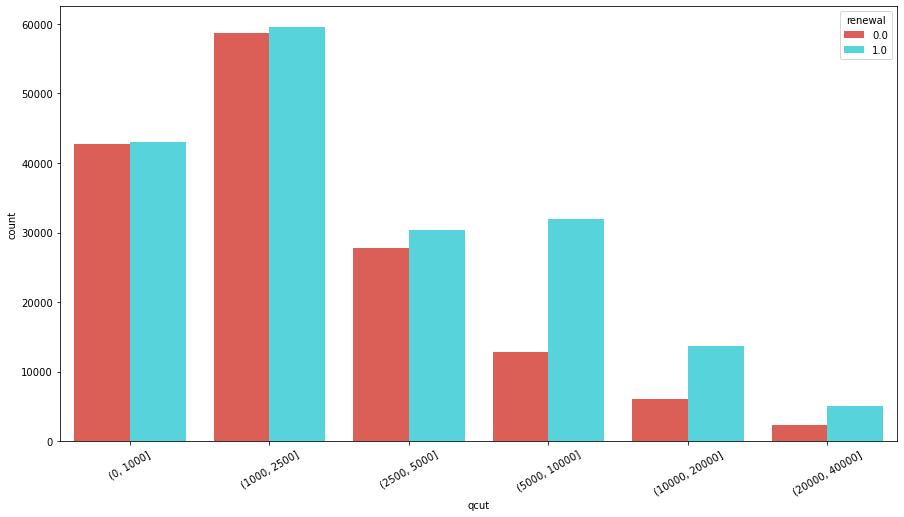

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
renewed_leases = renewal.copy()
cut_bins = [0, 1000, 2500, 5000, 10000, 20000, 40000]
renewed_leases['qcut'] = pd.cut(renewed_leases['sqft_max'], bins=cut_bins)

df = renewed_leases.groupby(['qcut', 'renewal']).sqft_max.count().reset_index().\
    rename(columns={'sqft_max': 'count'})
# Fixed to show distribution of bin
df

# # create plot
plt.figure(figsize = (15,8))
ax=sns.barplot(x = 'qcut', y = 'count', hue = 'renewal', data = df,
            palette = 'hls',
           # order = ['male', 'female'],  
            capsize = 0.05,             
            saturation = 8,             
            errcolor = 'gray', errwidth = 2,  
            ci = 'sd')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)